In [1]:
# import packages
import gym
import numpy as np
import matplotlib.pyplot as plt
from keras_radam import RAdam
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
# test observation cartpole

env = gym.make("CartPole-v0")
observation = env.reset()

for i in range(1000):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)

    if (i+1)%100 == 0:
        print(i+1, observation, reward, done, info)
        
    if done:
        observation = env.reset()

env.close()

100 [-0.02861677 -0.35610364  0.08545073  0.44196761] 1.0 False {}
200 [ 0.03261811  0.22717525 -0.01794826 -0.29578712] 1.0 False {}
300 [-0.05142291 -1.20314819  0.06741883  1.67818845] 1.0 False {}
400 [ 0.02524344  0.39437841 -0.01845341 -0.56345756] 1.0 False {}
500 [-0.01393557  0.14972083  0.13178496  0.30214833] 1.0 False {}
600 [-0.00940932 -0.21794437 -0.07053286 -0.078053  ] 1.0 False {}
700 [ 0.15933754  0.6436702  -0.21252467 -1.2486151 ] 1.0 True {}
800 [ 0.02076679  0.76194649 -0.11274565 -1.48048368] 1.0 False {}
900 [-0.02197701  0.36115349 -0.0666353  -0.72957359] 1.0 False {}
1000 [-0.03097604  0.54892148  0.00409361 -0.86426983] 1.0 False {}


In [3]:
# env create
env = gym.make('CartPole-v0')

# make model 
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(4,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='linear')) # 0 or 1

model.compile(loss='mse', optimizer=RAdam())

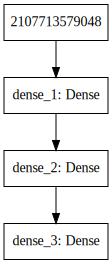

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [5]:
# collect Q
s = np.array([1,0,1,0])

model.predict(s.reshape(1,4))

array([[-0.26364708, -0.4174099 ]], dtype=float32)

In [6]:
# weight init
ws = model.get_weights()

In [7]:
import collections

memory = collections.deque(maxlen = 10000)

In [8]:
s = env.reset()

In [9]:
for i in range(32):
    action = env.action_space.sample() # np.random.randint(2)
    s2, r, done, _ = env.step(action)
    
    memory.append([s, action, r, done, s2])
    
    s = env.reset() if done else s2 # done 이면 리셋

In [10]:
len(memory)

32

In [11]:
display(memory[0], memory[-1])

[array([ 0.02260046, -0.01159818,  0.01786278,  0.00580626]),
 1,
 1.0,
 False,
 array([ 0.0223685 ,  0.1832631 ,  0.01797891, -0.28118764])]

[array([-0.154694  , -1.36514973,  0.1639523 ,  1.80262286]),
 0,
 1.0,
 False,
 array([-0.181997  , -1.56168056,  0.20000476,  2.14145217])]

In [12]:
epsilon = 1.0 # 처음에는 탐험만 수행한다. (랜덤 행동)
gamma = 0.99 # 감쇠율 (discount factor, 미래 보상을 얼마나 중요시할 지를 결정)
returns = [] # 에피소드 당 총보상값을 저장한다
count = 0

In [13]:
# 총 보상이 200 이상이 되면 그만 학습한다.
for episode in range(300):
    
    total_reward = 0 # 에피소스당 총보상값
    
    s = env.reset()
    
    for i in range(200): # 한 에피소드당 최대 200번만 행동한다
        
        ### 탐험 확률 지정 (1 부터 시작해서 점점 낮아지다 최소값은 1%)
        epsilon = 0.01 + (1-0.01)*np.exp(-0.0001*count)
        count += 1
        
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # 랜덤 행동
        else:
            action = np.argmax(model.predict(s.reshape(1,4))[0]) # Q값이 높은 행동 선택
            
        s2, r, done, _ = env.step(action)
        
        total_reward += r
        
        memory.append([s, action, r, done, s2])
        
        ### 학습 (배치크기는 32)
        indices = np.random.choice(len(memory), 32, replace=False)
        samples = [memory[i] for i in indices]
        
        X = np.zeros([32,4]) # 입력 상태값
        y = np.zeros([32,2]) # 목표 Q값
        
        for i, sample in enumerate(samples): # sample -> [s,a,r,done,s2]
            X[i] = sample[0]
            y[i] = model.predict(sample[0].reshape(1,4))[0]
            
            if sample[3] == True: # done
                y[i][sample[1]] = sample[2]
            else:
                y[i][sample[1]] = sample[2] + gamma*np.max(model.predict(sample[-1].reshape(1,4))[0])
                
        model.fit(X, y, epochs=1, verbose=False)
        
        if done:
            break
        else:
            s = s2
            
    print('Episode: %d, Reward: %d, Epsilon: %.5f' % (episode+1, total_reward, epsilon))
    if total_reward >= 200:
        break
    returns.append(total_reward)

Episode: 1, Reward: 14, Epsilon: 0.99871
Episode: 2, Reward: 11, Epsilon: 0.99763
Episode: 3, Reward: 37, Epsilon: 0.99398
Episode: 4, Reward: 24, Epsilon: 0.99162
Episode: 5, Reward: 19, Epsilon: 0.98976
Episode: 6, Reward: 12, Epsilon: 0.98858
Episode: 7, Reward: 14, Epsilon: 0.98721
Episode: 8, Reward: 30, Epsilon: 0.98429
Episode: 9, Reward: 15, Epsilon: 0.98283
Episode: 10, Reward: 14, Epsilon: 0.98146
Episode: 11, Reward: 12, Epsilon: 0.98030
Episode: 12, Reward: 24, Epsilon: 0.97797
Episode: 13, Reward: 17, Epsilon: 0.97633
Episode: 14, Reward: 12, Epsilon: 0.97517
Episode: 15, Reward: 10, Epsilon: 0.97421
Episode: 16, Reward: 16, Epsilon: 0.97266
Episode: 17, Reward: 29, Epsilon: 0.96988
Episode: 18, Reward: 26, Epsilon: 0.96738
Episode: 19, Reward: 30, Epsilon: 0.96452
Episode: 20, Reward: 9, Epsilon: 0.96366
Episode: 21, Reward: 37, Epsilon: 0.96014
Episode: 22, Reward: 15, Epsilon: 0.95871
Episode: 23, Reward: 16, Epsilon: 0.95719
Episode: 24, Reward: 43, Epsilon: 0.95313
Ep

In [14]:
# 학습 시킨 모델을 이용하여 cartpole test

for epoch in range(3):
    env.reset()
    
    done = False
    n = 0
    while not done:
        #a = np.random.randint(2)
        a = np.argmax(model.predict(s.reshape(1,4))[0])
        s, r, done, info = env.step(a)
        n += 1
        env.render()
        #print(s, r, done, info)
        
    print('Epoch: %d, Count: %d' % (epoch+1, n))
    print(s, r, done, info)
    #input()
    
env.close()

Epoch: 1, Count: 180
[1.57518219 0.652486   0.20982482 0.91238075] 1.0 True {}
Epoch: 2, Count: 200
[-0.63752195 -0.32772351 -0.014283    0.1001671 ] 1.0 True {'TimeLimit.truncated': True}
Epoch: 3, Count: 200
[0.47312438 0.41005765 0.06962299 0.02027365] 1.0 True {'TimeLimit.truncated': True}


In [15]:
# 위 확인시 생각보다 잘버티는걸 확인할 수 있었습니다. 아마 총 리워드가 천점이상 넘어가면 계속 버티고 있지않을까 예상합니다.